# HiGHS Key Insights

In [ ]:
import pandas as pd
import yaml

# Load HiGHS variant results
highs_results = pd.read_csv("infrastructure/benchmarks/runtime_optimized/highs_hipo_prelim_results.csv")

# Load main benchmark results
main_results = pd.read_csv("main_results.csv")

# Get matching benchmarks
highs_benchmarks = highs_results[highs_results['Benchmark'] != 'reference-benchmark'][['Benchmark', 'Size']].drop_duplicates()

# Extract matching results from main_results
matching_benchmarks = []
for _, row in highs_benchmarks.iterrows():
    matching = main_results[(main_results['Benchmark'] == row['Benchmark']) & (main_results['Size'] == row['Size'])]
    if len(matching) > 0:
        matching_benchmarks.append(matching)

# Combine results
if matching_benchmarks:
    main_matching = pd.concat(matching_benchmarks, ignore_index=True)
    results = pd.concat([highs_results, main_matching], ignore_index=True)
    print(f"Combined dataset: {len(results)} results")
else:
    results = highs_results
    print(f"Using HiGHS results only: {len(results)} results")

results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]

print(f"Solvers: {sorted(results['Solver'].unique())}")
print(f"Benchmarks: {sorted([b for b in results['Benchmark'].unique() if b != 'reference-benchmark'])}")

## How do HiGHS variants compare?

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from humanize import naturaldelta
from matplotlib.patches import Patch

In [ ]:
max_num_solvers = 15  # Adjust based on total number of solvers

# Color map for HiGHS variants and other solvers
color_map = {
    "highs": "#43BF94",  # green - baseline
    "highs-binary": "#2D8A63",  # darker green
    "highs-hipo": "#F66C49",  # red/orange - primary HIPO variant
    "highs-hipo-ipm": "#F9A826",  # orange
    "highs-hipo-32": "#3B82F6",  # blue
    "highs-hipo-64": "#7C3AED",  # purple
    "cbc": "#F9CD5A",  # yellow
    "glpk": "#9333EA",  # purple
    "gurobi": "#DC2626",  # bright red
    "scip": "#0EA5E9",  # sky blue
}


def plot_runtime_slowdowns(df, figsize=(12, 6)):
    """Plots relative runtimes (slowdown factors) in a bar chart.

    Expects df to have columns: Benchmark, Solver, Runtime (s), Status, Timeout
    """
    if "bench-size" in df.columns:
        df["Benchmark"] = df["bench-size"]
    # Fill NaN runtimes and non-ok statuses with TO value
    df.loc[df["Runtime (s)"].isna(), "Runtime (s)"] = df["Timeout"]
    df.loc[df.query('Status != "ok"').index, "Runtime (s)"] = df["Timeout"]

    # Find the fastest solver for each benchmark
    df_ok = df.query('Status == "ok"')
    fastest_runtimes = df_ok.loc[df_ok.groupby("Benchmark")["Runtime (s)"].idxmin()]

    # Sort benchmarks by fastest runtime
    sorted_benchmarks = fastest_runtimes.sort_values("Runtime (s)").reset_index(
        drop=True
    )

    # Normalize runtimes to find each solver's slowdown factor
    df = df.merge(
        fastest_runtimes[["Benchmark", "Runtime (s)"]],
        on="Benchmark",
        suffixes=("", "_fastest"),
    )
    df["Slowdown"] = df["Runtime (s)"] / df["Runtime (s)_fastest"]
    max_slowdown = max(df.query('Status == "ok"')["Slowdown"])
    df.loc[df.query('Status != "ok"').index, "Slowdown"] = 1.1 * max_slowdown

    width = 1 / (max_num_solvers + 1)  # the width of the bars

    fig, ax = plt.subplots(figsize=figsize, layout="constrained")

    # Add a dotted line at y=1
    ax.axhline(1, color="grey", linestyle="--")

    # Plot each benchmark
    for i, benchmark in enumerate(sorted_benchmarks["Benchmark"]):
        benchmark_data = df[df["Benchmark"] == benchmark].sort_values(
            "Slowdown", ascending=True
        )
        num_solvers = len(benchmark_data)
        # Compute x-axis offsets
        xs = i + (np.arange(num_solvers) * width) - 0.5 + width
        # Pick colors based on solvers
        colors = [
            color_map.get(r["Solver"], "#888888")
            if r["Status"] == "ok"
            else (color_map.get(r["Solver"], "#888888"), 0.2)
            for _, r in benchmark_data.iterrows()
        ]
        ax.bar(xs, benchmark_data["Slowdown"], width, color=colors)
        # Add text labels on top of bars
        for j, x in enumerate(xs):
            if benchmark_data.iloc[j]["Status"] == "ok":
                y = benchmark_data.iloc[j]["Slowdown"] + 0.05
                label = f"{benchmark_data.iloc[j]['Slowdown']:.2f}x"
                kwargs = {}
            else:
                y = benchmark_data.iloc[j]["Slowdown"] + 0.05
                label = benchmark_data.iloc[j]["Status"]
                kwargs = {"color": "red", "weight": "bold"}
            ax.text(
                x,
                y,
                label,
                ha="center",
                fontsize=8,
                **kwargs,
            )

    # Set x-ticks and labels
    xlabels = [
        f"{r['Benchmark']}\\nFastest: {naturaldelta(r['Runtime (s)'])}"
        for _, r in sorted_benchmarks.iterrows()
    ]
    ax.set_xticks(np.arange(len(sorted_benchmarks)), xlabels)

    # Add labels and title
    ax.set_ylabel("Relative Runtime (normalized)")
    ax.set_title("Solver Runtime Comparison")
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in color_map.items()],
        title="Solver",
        loc="upper right",
        fontsize=8,
        ncol=2
    )

In [17]:
def plot_runtime_slowdowns_of(results, to_plot, figsize=(12, 6)):
    to_plot_results = results[results["bench-size"].isin(to_plot)]

    # Remove old solver versions if multiple versions exist
    to_plot_results = to_plot_results.sort_values(
        ["bench-size", "Solver", "Solver Release Year"]
    ).drop_duplicates(["bench-size", "Solver"], keep="last")

    plot_runtime_slowdowns(to_plot_results, figsize=figsize)

### All Benchmarks Comparison

In [18]:
# Filter out reference benchmarks
actual_benchmarks = results[results["Benchmark"] != "reference-benchmark"].copy()

# Get unique benchmark-size combinations
unique_benchmarks = set(actual_benchmarks["bench-size"].unique())

print(f"Found {len(unique_benchmarks)} unique benchmarks:")
for b in sorted(unique_benchmarks):
    print(f"  - {b}")

Found 3 unique benchmarks:
  - Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon24_Day332-1-1h
  - pypsa-eur-elec-op-4-3h
  - pypsa-eur-elec-op-ucconv-2-3h


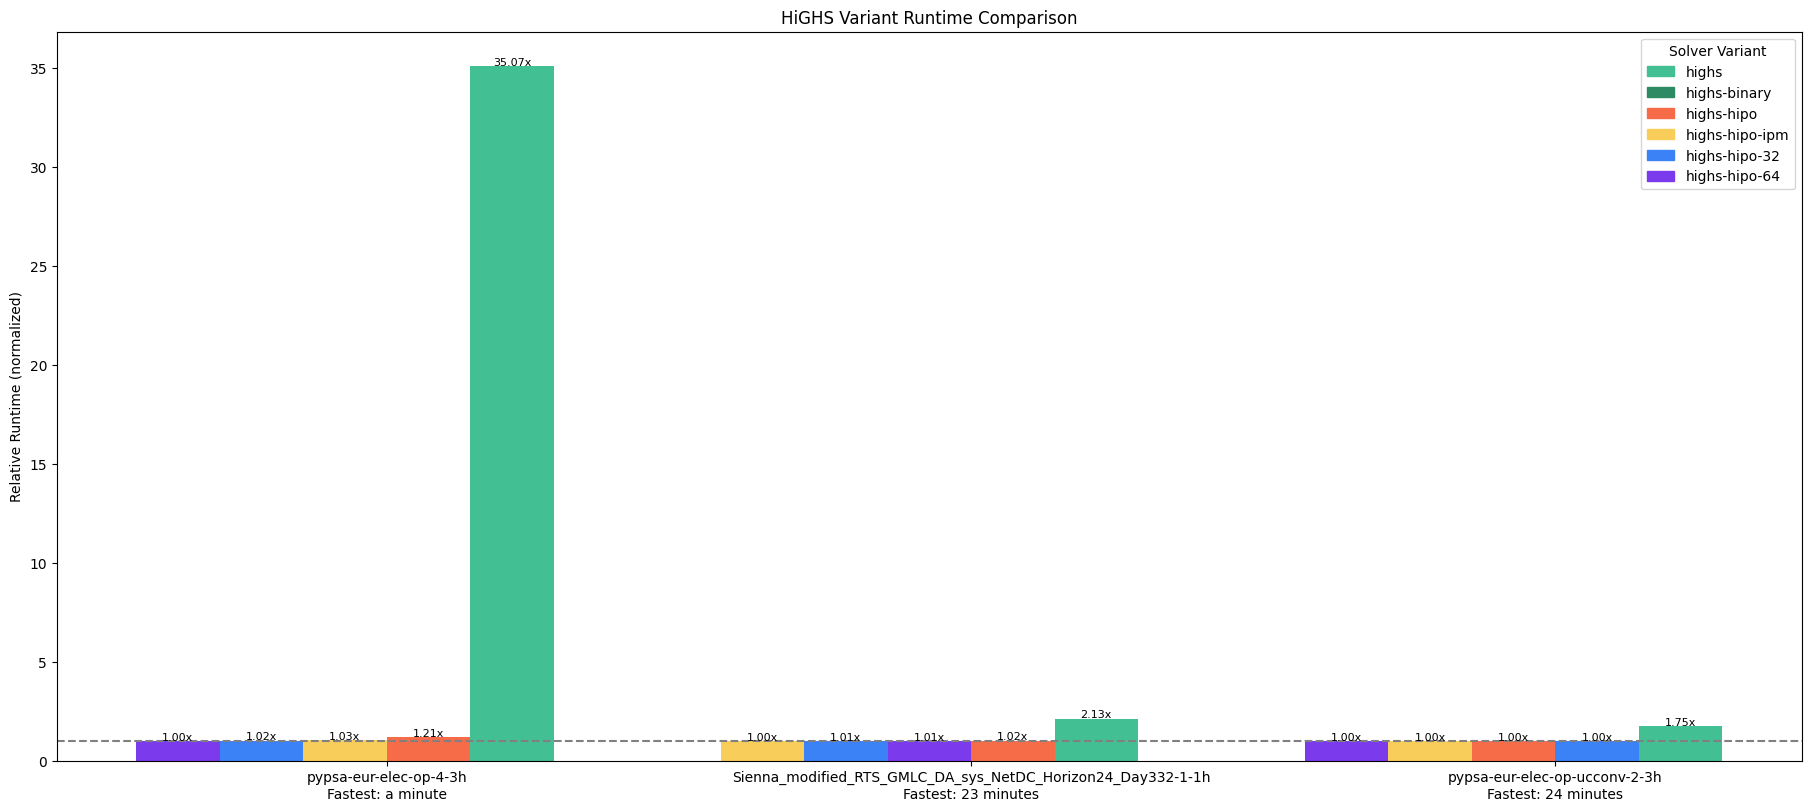

In [19]:
# Plot all benchmarks
plot_runtime_slowdowns_of(results, unique_benchmarks, figsize=(18, 8))

## Performance Statistics

In [20]:
# Calculate speedup statistics for each variant compared to baseline highs
baseline_solver = "highs"

# Get baseline runtimes for each benchmark
baseline_data = actual_benchmarks[actual_benchmarks["Solver"] == baseline_solver][
    ["bench-size", "Runtime (s)"]
].rename(columns={"Runtime (s)": "Baseline Runtime"})

# Merge with all results
comparison = actual_benchmarks.merge(baseline_data, on="bench-size", how="left")

# Calculate speedup
comparison["Speedup"] = comparison["Baseline Runtime"] / comparison["Runtime (s)"]

# Summary statistics by solver
speedup_summary = (
    comparison.groupby("Solver")["Speedup"]
    .agg(["mean", "median", "min", "max", "std"])
    .round(3)
)

print("Speedup Statistics (relative to highs 1.10.0):")
print(speedup_summary)

Speedup Statistics (relative to highs 1.10.0):
                  mean  median    min     max     std
Solver                                               
highs            1.000   1.000  1.000   1.000   0.000
highs-hipo      10.943   2.097  1.747  28.985  15.626
highs-hipo-32   12.745   2.115  1.747  34.374  18.732
highs-hipo-64   12.973   2.099  1.752  35.069  19.136
highs-hipo-ipm  12.611   2.130  1.748  33.954  18.485


## Memory Usage Comparison

In [21]:
# Memory usage comparison
memory_summary = (
    actual_benchmarks.groupby("Solver")["Memory Usage (MB)"]
    .agg(["mean", "median", "min", "max", "std"])
    .round(2)
)

print("Memory Usage Statistics (MB):")
print(memory_summary)

Memory Usage Statistics (MB):
                   mean   median      min      max      std
Solver                                                     
highs           2421.27  1528.29  1021.22  4714.30  2001.94
highs-hipo      1482.19  1079.16   896.22  2471.21   861.38
highs-hipo-32   1391.33   880.93   827.72  2465.35   930.50
highs-hipo-64   1389.16   880.41   820.60  2466.46   933.45
highs-hipo-ipm  1394.03   891.14   820.87  2470.09   932.56


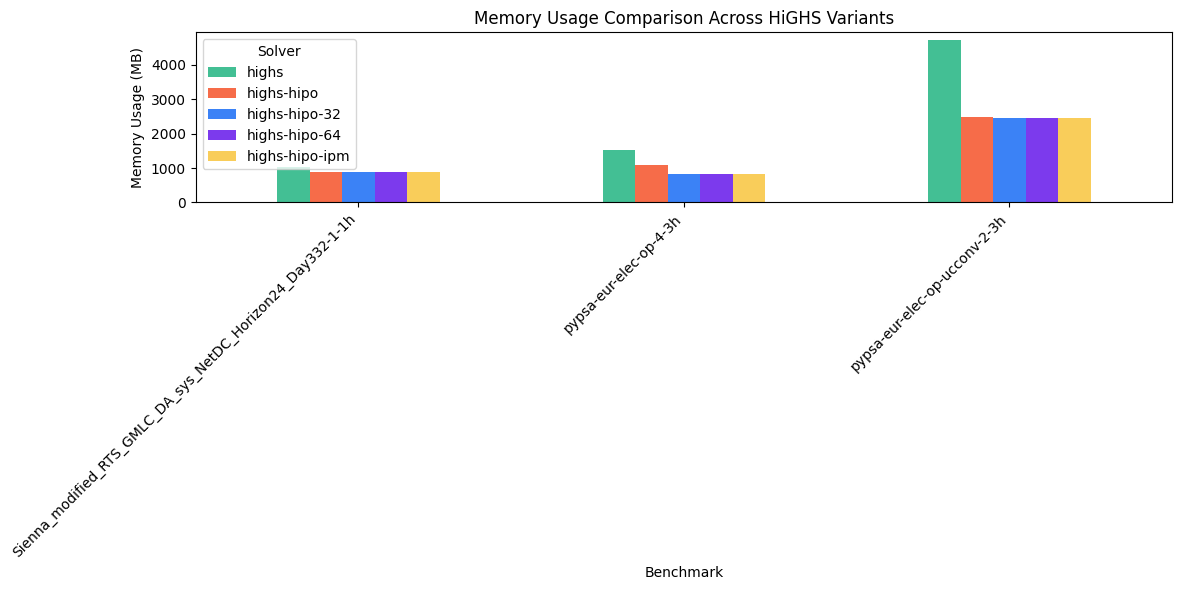

In [22]:
# Plot memory usage comparison
fig, ax = plt.subplots(figsize=(12, 6))

pivot_memory = actual_benchmarks.pivot_table(
    index="bench-size", columns="Solver", values="Memory Usage (MB)", aggfunc="mean"
)

pivot_memory.plot(kind="bar", ax=ax, color=[color_map.get(s, "#888888") for s in pivot_memory.columns])
ax.set_ylabel("Memory Usage (MB)")
ax.set_xlabel("Benchmark")
ax.set_title("Memory Usage Comparison Across HiGHS Variants")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Runtime vs Memory Trade-off

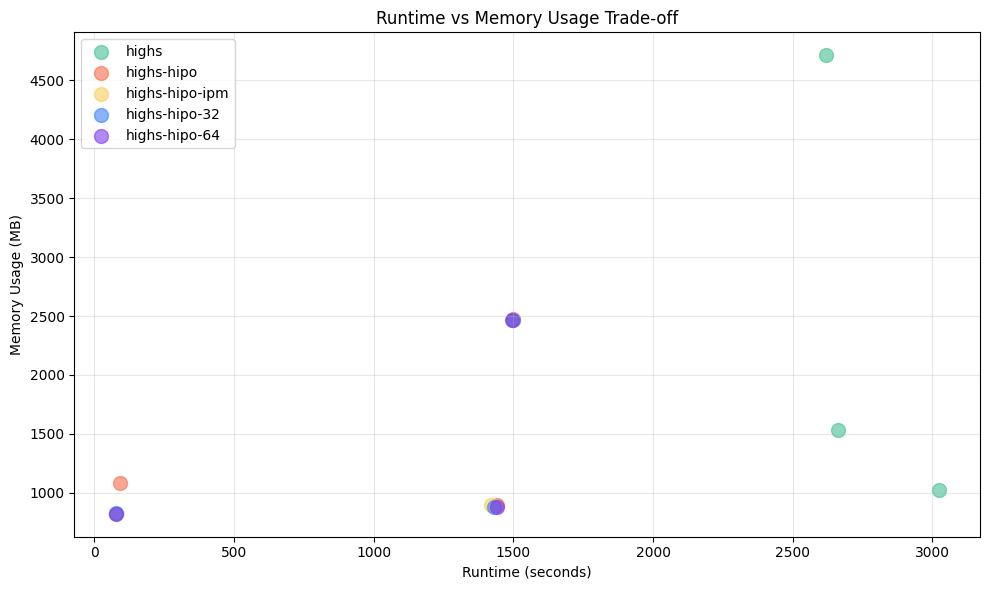

In [23]:
# Scatter plot: runtime vs memory usage
fig, ax = plt.subplots(figsize=(10, 6))

for solver in actual_benchmarks["Solver"].unique():
    solver_data = actual_benchmarks[actual_benchmarks["Solver"] == solver]
    ax.scatter(
        solver_data["Runtime (s)"],
        solver_data["Memory Usage (MB)"],
        label=solver,
        alpha=0.6,
        s=100,
        color=color_map.get(solver, "#888888"),
    )

ax.set_xlabel("Runtime (seconds)")
ax.set_ylabel("Memory Usage (MB)")
ax.set_title("Runtime vs Memory Usage Trade-off")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Detailed Benchmark-by-Benchmark Analysis

In [24]:
# For each benchmark, show detailed comparison
for bench in sorted(unique_benchmarks):
    bench_data = actual_benchmarks[actual_benchmarks["bench-size"] == bench]

    print(f"\n{'=' * 80}")
    print(f"Benchmark: {bench}")
    print(f"{'=' * 80}")

    # Create summary table
    summary = bench_data[["Solver", "Runtime (s)", "Memory Usage (MB)", "Status"]].copy()
    summary = summary.sort_values("Runtime (s)")

    # Calculate speedup relative to baseline
    baseline_runtime = bench_data[bench_data["Solver"] == baseline_solver][
        "Runtime (s)"
    ].values
    if len(baseline_runtime) > 0:
        summary["Speedup vs highs"] = baseline_runtime[0] / summary["Runtime (s)"]
        summary["Speedup vs highs"] = summary["Speedup vs highs"].round(3)

    print(summary.to_string(index=False))
    print()


Benchmark: Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon24_Day332-1-1h
        Solver  Runtime (s)  Memory Usage (MB) Status  Speedup vs highs
highs-hipo-ipm  1419.042047            891.136     ok             2.130
 highs-hipo-32  1429.216380            880.932     ok             2.115
 highs-hipo-64  1439.916378            880.408     ok             2.099
    highs-hipo  1441.530234            896.220     ok             2.097
         highs  3022.784890           1021.224     ok             1.000


Benchmark: pypsa-eur-elec-op-4-3h
        Solver  Runtime (s)  Memory Usage (MB) Status  Speedup vs highs
 highs-hipo-64    75.898695            820.600     ok            35.069
 highs-hipo-32    77.434301            827.724     ok            34.374
highs-hipo-ipm    78.391278            820.868     ok            33.954
    highs-hipo    91.829032           1079.156     ok            28.985
         highs  2661.703448           1528.292     ok             1.000


Benchmark: pypsa-eur-elec-

## Reference Benchmark Consistency Check

Reference benchmark runs: 5

Runtime statistics:
count      5.000000
mean     198.627852
std       24.101481
min      180.758704
25%      181.042067
50%      182.754563
75%      216.364019
max      232.219908
Name: Runtime (s), dtype: float64

Coefficient of Variation: 0.1213
✗ Poor consistency (CV >= 10%)


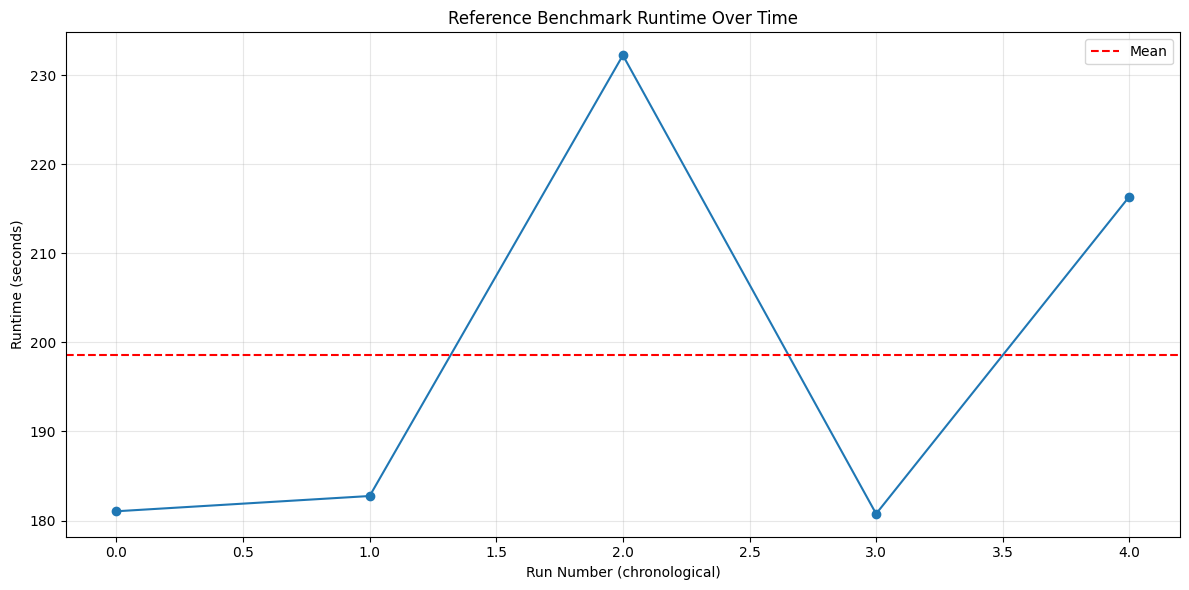

In [25]:
# Analyze reference benchmark to ensure consistent machine performance
reference_results = results[results["Benchmark"] == "reference-benchmark"].copy()

if len(reference_results) > 0:
    print(f"Reference benchmark runs: {len(reference_results)}")
    print(f"\nRuntime statistics:")
    print(reference_results["Runtime (s)"].describe())

    # Check coefficient of variation
    cv = (
        reference_results["Runtime (s)"].std() / reference_results["Runtime (s)"].mean()
    )
    print(f"\nCoefficient of Variation: {cv:.4f}")
    if cv < 0.05:
        print("✓ Good consistency (CV < 5%)")
    elif cv < 0.10:
        print("⚠ Moderate consistency (5% <= CV < 10%)")
    else:
        print("✗ Poor consistency (CV >= 10%)")

    # Plot reference benchmark over time
    fig, ax = plt.subplots(figsize=(12, 6))
    reference_sorted = reference_results.sort_values("Timestamp")
    ax.plot(range(len(reference_sorted)), reference_sorted["Runtime (s)"], "o-")
    ax.axhline(
        reference_sorted["Runtime (s)"].mean(),
        color="red",
        linestyle="--",
        label="Mean",
    )
    ax.set_xlabel("Run Number (chronological)")
    ax.set_ylabel("Runtime (seconds)")
    ax.set_title("Reference Benchmark Runtime Over Time")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No reference benchmark results found.")

## Key Findings Summary

In [26]:
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# 1. Best overall variant
avg_runtimes = actual_benchmarks.groupby("Solver")["Runtime (s)"].mean().sort_values()
print(f"\n1. Average Runtime Ranking:")
for i, (solver, runtime) in enumerate(avg_runtimes.items(), 1):
    print(f"   {i}. {solver}: {runtime:.2f}s")

# 2. Best speedup
print(f"\n2. Best Average Speedup vs {baseline_solver}:")
speedup_by_solver = (
    comparison[comparison["Solver"] != baseline_solver]
    .groupby("Solver")["Speedup"]
    .mean()
    .sort_values(ascending=False)
)
for solver, speedup in speedup_by_solver.items():
    print(f"   {solver}: {speedup:.3f}x")

# 3. Memory efficiency
print(f"\n3. Average Memory Usage:")
avg_memory = actual_benchmarks.groupby("Solver")["Memory Usage (MB)"].mean().sort_values()
for solver, memory in avg_memory.items():
    print(f"   {solver}: {memory:.2f} MB")

# 4. Success rate
print(f"\n4. Success Rate:")
success_rate = (
    actual_benchmarks.groupby("Solver")["Status"]
    .apply(lambda x: (x == "ok").sum() / len(x) * 100)
    .sort_values(ascending=False)
)
for solver, rate in success_rate.items():
    print(f"   {solver}: {rate:.1f}%")


KEY FINDINGS

1. Average Runtime Ranking:
   1. highs-hipo-ipm: 998.70s
   2. highs-hipo-32: 1002.24s
   3. highs-hipo-64: 1003.88s
   4. highs-hipo: 1011.08s
   5. highs: 2768.18s

2. Best Average Speedup vs highs:
   highs-hipo-64: 12.973x
   highs-hipo-32: 12.745x
   highs-hipo-ipm: 12.611x
   highs-hipo: 10.943x

3. Average Memory Usage:
   highs-hipo-64: 1389.16 MB
   highs-hipo-32: 1391.33 MB
   highs-hipo-ipm: 1394.03 MB
   highs-hipo: 1482.19 MB
   highs: 2421.27 MB

4. Success Rate:
   highs: 100.0%
   highs-hipo: 100.0%
   highs-hipo-32: 100.0%
   highs-hipo-64: 100.0%
   highs-hipo-ipm: 100.0%
